# MaSim Country Calibration

This note book is used for running the country calibration processes for eventual use in the experimental simulation process where various response strategies are modeled. This notebook and the accompanying toolkit was developed by [James Brodovsky](https://github.com/jbrodovsky) and Sarit Adhikari as part of the calibration efforts for Burkino Faso and Mozambique in 2025. This notebook is ***version two*** and is being developed alongside the calibration of Angola and a design shift around batch processing on the Nessun Dorma cluster that the lab controls. The Temple University Owls Nest cluster will be decommissioned sometime in 2026 as such there will be a shift in how batch processing is handled.

This Python package is developed with Python 3.10+ and is compliant with PEP 621. It is recommended to use a virtual environment manager such as `uv` or `venv` to manage dependencies. The package dependencies are listed in the `pyproject.toml` file. While any compliant environment manager should work, `uv` is recommended and the officially supported environment manager.


## Installation

Installation is in two parts. First, clone this repository to your local machine. Second, install the `masim_analysis` package into a virtual environment, e.g., using `pip` or `uv`.

```bash
pip install -e .
```

If you are using `uv` (and you should!) install via

```bash
uv pip install -e .
```

This will install the package in an editable mode, allowing you to make changes to the code and have them reflected in your local environment. If for some reason you are not seeing the changes reflected, try re-installing the package locally using the above commands again.

```python 
from src.masim_analysis import *
```
where `*` is the specific module you are interested in.

## Package and repo structure

Please make note of the following directory structures: `conf` and `data`. These are the primary two directories for experimental country data and configuration files. The `conf` directory contains the configuration (`.yml`) files for the simulation, while the `data` directory contains the data files used in the simulation (typically raster `.asc` files).

Each of these folders is organized by country. For example, if you are working with Mozambique, which we abbreviate as `moz`, the directory structure would look like this:

```
data/
    moz/
        calibration/
        ...
conf/
    moz/
        calibration/
        ...
```
Additionally the templates folder contains the template files for the configuration files. These are used to generate the .yml files for the simulation. This templating system is gradually being phased out in favor of a more structured approach using Python data classes in the `configure` module. Ultimately, this package communicates with the MaSim simulation through a `.yml` configuration file that can still be created manually if you desire.

## How to use this notebook

This notebook should be thought of as a structured interactive prompt that guides you through the process of calibrating and validating a country. The code sections are generally organized into sections that can be run independently. The notebook breaks up individual workflows by using markdown headings and note blocks. Due to the some what long-running nature of the tasks that calibration and validation involve, you'll sometimes have to wait and shutdown the kernel the notebook is running on and pick up where you left off another time.

To that end, this notebook is designed to make things organized but also segmented. Keep calibration constants (name, population, etc.) in a block below this and make sure to run that block every time you start the notebook. Module and library imports should be handled in the workflow segment you are currently working on. It is recommend (for speed of execution) to separate out imports from code execution to save time on re-importing.

Workflows are generally separated by a horizontal rule:

--- 

## Calibration efforts

The primary calibration point is to relate the beta parameter (rate of infection/biting) with the actual reported prevelence, given the population size of a given map pixel and treatment access rate. This involves a few steps. As a preliminary step, obtain the relevant raster files that contain population data, district mapping values, treatment access, and prevalence (pfpr2-10, or a similar name) and place it under `data/<country>`. Fictitious calibration data will be stored under `data/<country>/calibration`. Create a new branch in the git repository for the calibration process. This is important to keep track of changes and to avoid conflicts with the main branch. The main branch should be reserved as a branching off point for strategy and treatment analysis or new calibration efforts. The workflow there should be to branch off from the main branch, implement the strategies and treatments, and then merge back in any useful changes. Strategy and treament analysis shouldn't be a main contribution to the main branch. The calibration branch name should be descriptive and include the country name, e.g., `calibration-moz`.

Calibration then occurs in two phases and should be done on a separate git branch. The first phase is generating the simulated data for beta calibration. This creates the fictitious configuration and data files. This concludes with several command and job files to be run on a cluster. At the moment this is configured to work on Temple University's OwlsNest cluster, but the resulting `*_cmds.txt` files simply contain a list of shell commands that execute the simulation and should be generalizable to whatever parallel computing cluster system you are using.

The second phase is started when the batch processing is completed and downloaded locally to the `output/<country>/calibration` directory. These files are then summarized and the prevalence and beta values are fit using a log-sigmoid curve fit when broken down by pixel population and treatment access rate. These fits are then used to generate the beta map for eventual use in the experimental simulation.

---

## Basic parameters

There are a few country specific parameters that we need to develop and organize. These parameters are frequently used and are listed below:

- `name`: The country code name. Usually two or three letters. Examples: `moz` for Mozambique, `bf` for Burkino Faso, `rwa` for Rwanda, `tz` for Tanzania, etc.
- `birth_rate`: The birth rate of the country. This is used to calculate the population growth rate. This is usually a constant value for the country. Data is typically given in births per 1000 people. Normalize that data to a decimal value.
- `target_population`: The population of the country in the calibration target year.
- `initial_age_structure`: The initial age bins of the country. 
- `age_distribution`: The age distribution of the country as percentages corresponding to the age bins.
- `death_rate`: The death rate of the country corresponding to the age bins.
- `access_rates`: the treatment access rates for the country. This is determined by the unique values in the raster file typically called `<name>_treatementseeking.asc`

Some of these are configuration parameters that are fed into the `MaSim` simulation. Others are simply descriptive (e.g. `name`) are are used to organize files. It is useful to have these parameters as variables. Once we have gone through the initial tuning, these parameters are stable and it is useful to simply keep them in a Python source file and import them as neccessary.

## Directory Setup

First: what is the long-form name of the country your are working with?

In [25]:
long_name = "Angola"

Second: what is the short-form country code?

In [26]:
name = "ago"

Now we'll do a basic file system configuration for our project.

In [27]:
from masim_analysis import commands

commands.setup_directories(name)

All required raster files found in data/ago.


After this initial folder configuration is set up copy the data from the country folder on the drop box into `data/<name>`. This should be a collection of raster (`.asc`) and `.csv` files. At a minimum these should include: 
- `<name>_districts.asc` (mapping of individual raster pixels to larger scale provinces or health districts)
- `<name>_population.asc` (calibration year population)
- `<name>_initialpopulation.asc` (backed out initial population)
- `<name>_pfpr210.asc` (pfpr210 raster)
- `<name>_traveltime.asc` (travel time raster)
- `<name>_treatmentseeking.asc` (treatment seeking raster)

### Raster data exploration

The first calibration step is to read in the relevant rasters to get a sense of some of the big picture data. The rasters are stored in the `data/<country>` directory. This is then used to get some basic statistics to run calibration. Of primary concern is getting the value of the initial population, calibration year population, `

In [28]:
import os
import pandas as pd
from masim_analysis import utils

districts, _ = utils.read_raster(os.path.join("data", name, f"{name}_districts.asc"))
population, _ = utils.read_raster(os.path.join("data", name, f"{name}_initialpopulation.asc"))
prevalence, _ = utils.read_raster(os.path.join("data", name, f"{name}_pfpr210.asc"))
district_names = pd.read_csv(os.path.join("data", name, f"{name}_mapping.csv"), index_col="ID")
names = district_names.to_dict()[district_names.columns[0]]


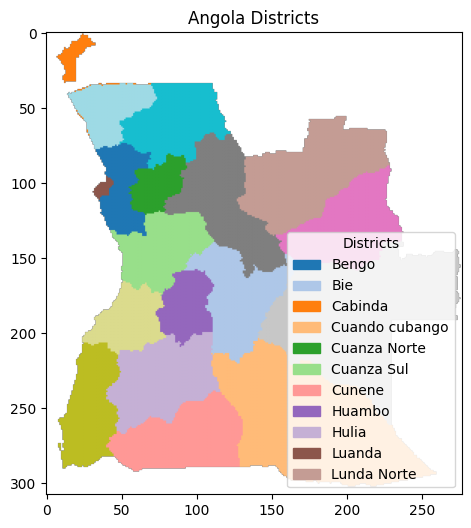

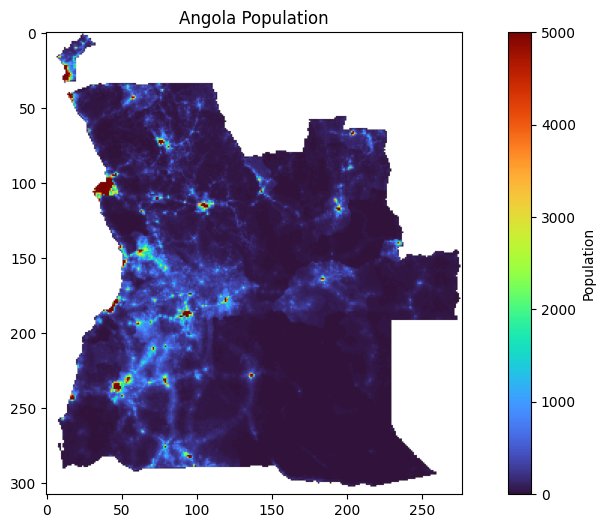

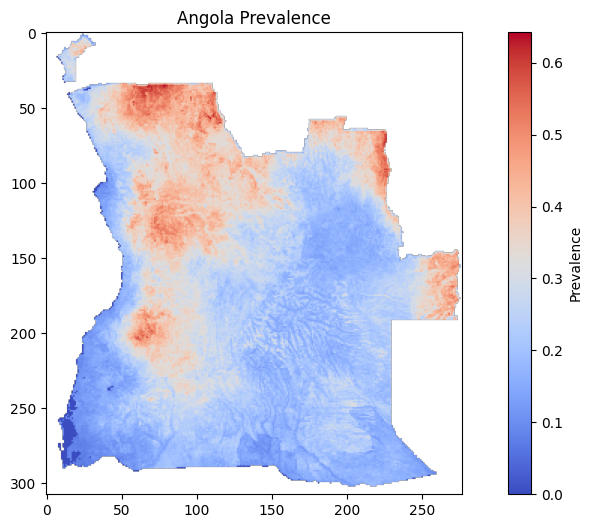

In [29]:
dist_fig = utils.plot_districts(districts, names, long_name, fig_size=(12, 6), loc="lower right")
pop_fig = utils.plot_population(population, long_name, fig_size=(12, 6), population_upper_limit=5000)
pfpr_plot = utils.plot_prevalence(prevalence, long_name, fig_size=(12, 6))

### Convert seasonality rainfall data to pattern data for V4.2
This will check if `name_seasonality.csv` is available and determine the format is for v4.1 or v4.2. Since we will use v4.2 after all so v4.1 format will be converted to v4.2 here.
Note that a 1 location seasonality file will be generated for testing as well

In [30]:
# check seasonaility csv file
seasonality_csv_path = os.path.join("data", name, f"{name}_seasonality.csv")
if not os.path.exists(seasonality_csv_path):
    print(f"Seasonality CSV file not found at {seasonality_csv_path}")
    exit(1)

seasonality_df = pd.read_csv(seasonality_csv_path, header=None)
if seasonality_df.columns.tolist() == [0]:
    print(f"Seasonality CSV file does not have admin_unit_id column at {seasonality_csv_path}")
    print(f"Converting to pattern format...")
    unique_districts = list(set(districts.flatten()))
    valid_districts = [int(d) for d in unique_districts if d == d]

    all_district_pattern_df = pd.DataFrame()
    for district in sorted(valid_districts): 
        rainfall_df = pd.read_csv(os.path.join("data", name, f"{name}_seasonality.csv"),header=None)
        pattern_df = rainfall_df.T 
        pattern_df.columns = [f"day{i+1}" for i in range(len(pattern_df.columns))]
        pattern_df.insert(0, "admin_unit_id", district)
        all_district_pattern_df = pd.concat([all_district_pattern_df, pattern_df], ignore_index=True)
        
    #rename old file to old_seasonality_rainfall.csv
    os.rename(os.path.join("data", name, f"{name}_seasonality.csv"),
            os.path.join("data", name, f"{name}_seasonality_rainfall.csv"))
    all_district_pattern_df.to_csv(os.path.join("data", name, f"{name}_seasonality_pattern.csv"), index=False)
    all_district_pattern_df.to_csv(os.path.join("data", name, f"{name}_seasonality.csv"), index=False)
    
    # If valid districts > 1, then create a new file with the pattern format for 1 location only
    if len(valid_districts) > 1:
        first_district_pattern_df = all_district_pattern_df[all_district_pattern_df['admin_unit_id'] == valid_districts[0]]
        first_district_pattern_df.to_csv(os.path.join("data", name, f"{name}_seasonality_1_location.csv"), index=False)
else:
    print(f"Seasonality CSV file already has admin_unit_id column at {seasonality_csv_path}")
    seasonality_df = pd.read_csv(seasonality_csv_path)
    # Check if the file has more than one location
    if seasonality_df['admin_unit_id'].nunique() > 1:
        print(f"Seasonality CSV file has more than one location. Creating a new file with the pattern format for 1 location only...")
        first_district_pattern_df = seasonality_df[seasonality_df['admin_unit_id'] == seasonality_df['admin_unit_id'].unique()[0]]
        first_district_pattern_df.to_csv(os.path.join("data", name, f"{name}_seasonality_1_location.csv"), index=False)
    


Seasonality CSV file already has admin_unit_id column at data/ago/ago_seasonality.csv
Seasonality CSV file has more than one location. Creating a new file with the pattern format for 1 location only...


### Drug distribution rates

Each country has a different drug distribution rate. This will factor into the calibration file. Read in the raw file and process it to remove any unnecessary columns or rows.

In [31]:
drug_distribution = pd.read_csv(
    os.path.join("data", name, f"{name}_drugdistribution.csv"), index_col=0, na_values="-99"
)
drug_distribution

,al,qn,sp,cq,aq,as,other,act,aspirin
date,,,,,,,,,
2006,NaN,2.8,0.3,14.0,10.7,NaN,0.8,1.6,NaN
2007,NaN,2.8,0.3,14.0,10.7,NaN,0.8,1.6,NaN
2011,NaN,2.7,0.9,2.5,NaN,NaN,2.2,21.7,NaN
2015,NaN,9.3,8.3,2.0,7.0,NaN,1.6,76.7,NaN
2016,NaN,9.3,8.3,2.0,7.0,NaN,1.6,76.7,NaN
2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Drop any columns that are all NaN
drug_distribution.dropna(axis=1, how="all", inplace=True)
# Drop any rows that are all NaN
drug_distribution.dropna(axis=0, how="all", inplace=True)
# Fill any remaining NaN values with 0
drug_distribution.fillna(0, inplace=True)
# convert all columns to lowercase
drug_distribution.columns = [col.lower() for col in drug_distribution.columns]
# Convert to percentages [0, 1]
drug_distribution = drug_distribution.div(100)
drug_distribution

,qn,sp,cq,aq,other,act
date,,,,,,
2006,0.028,0.003,0.140,0.107,0.008,0.016
2007,0.028,0.003,0.140,0.107,0.008,0.016
2011,0.027,0.009,0.025,0.000,0.022,0.217
2015,0.093,0.083,0.020,0.070,0.016,0.767
2016,0.093,0.083,0.020,0.070,0.016,0.767


If in the case that the sum of the distribution rates does not equal 1.0, then you will need to normalize the values so that they do for the purposes of the simulation.

We then relate this to the `DRUG_DB` and `THERAPY_DB` dictionary in `masim_analysis.configure`. Note that the drug distribution may be either a single drug or a combination of drugs. For instance, `al` is a combination of artemether and lumefantrine. This would correspond to a *therapy* entry in `THERAPY_DB` that uses both the *artemether* and *lumefantrine* drugs from `DRUG_DB`.

In [33]:
from masim_analysis.configure import DRUG_DB, THERAPY_DB

print("DRUGS:")
for idx in DRUG_DB.keys():
    print(f"Drug {idx}: {DRUG_DB[idx]['name']}")
print("===========================")
print("THERAPIES:")
for idx in THERAPY_DB.keys():
    drug_ids = THERAPY_DB[idx]["drug_id"]
    print(f"Therapy {idx}: {[DRUG_DB[drug_id]['name'] for drug_id in drug_ids]}")

DRUGS:
Drug 0: ART
Drug 1: AQ
Drug 2: SP
Drug 3: CQ
Drug 4: LUM
Drug 5: PQ
Drug 6: MF
Drug 7: QUIN
THERAPIES:
Therapy 0: ['ART', 'AQ']
Therapy 1: ['ART', 'LUM']
Therapy 2: ['ART', 'MF']
Therapy 3: ['ART', 'PQ']
Therapy 4: ['AQ']
Therapy 5: ['ART']
Therapy 6: ['CQ']
Therapy 7: ['QUIN']
Therapy 8: ['SP']


We now create a mapping between the drug distribution table columns to the therapy ID numbers:

In [34]:
column_mapping: list[int] = [7, 8, 6, 4, 0, 0]

Now remove any un-needed columns from the drug distribution table (i.e. 'sum', 'aspirin', 'other')

In [35]:
# drug_distribution.drop(columns=["other"], inplace=True)

### Public/Private Distribution

For countries that have a public and private sector split, the overall strategy will be constructed using a MFT. For the overall distribution percentage, we use a weighted value based on the proportion of the split between public and private sector distributions. For example for a country with a 70/30 public/private split a therapy that has a 25% distribution rate in the public sector and a 50% distribution in the private sector would have an overall strategy distribution of 0.7 * 0.25 + 0.3 * 0.50 = 0.325. The private market, however, can be difficult to ascertain in some countries, particularly in the distribution of specific therapies. 

If there is no private market or no information on the private market, then we simply use the public sector distribution rates.

In [36]:
import numpy as np

market_distribution = pd.DataFrame(
    {
        "private":  0.895 * np.ones_like(drug_distribution.index),
        "public": 0.105 * np.ones_like(drug_distribution.index)
    },
    index= drug_distribution.index
)


We now apply the public/private market distribution to the drug distribution rates to get the overall distribution rates:

In [37]:
private_market = drug_distribution.mul(market_distribution["private"], axis=0)
public_market = drug_distribution.mul(market_distribution["public"], axis=0)
combined_distribution = private_market.add(public_market, fill_value=0)
combined_distribution

,qn,sp,cq,aq,other,act
date,,,,,,
2006,0.028,0.003,0.140,0.107,0.008,0.016
2007,0.028,0.003,0.140,0.107,0.008,0.016
2011,0.027,0.009,0.025,0.000,0.022,0.217
2015,0.093,0.083,0.020,0.070,0.016,0.767
2016,0.093,0.083,0.020,0.070,0.016,0.767


### Start and End Dates

Next we need to establish the calibration year, starting date, and ending date of the simulation. The calibration year is the year of the most recent data available, typically 2-3 years old.

In [38]:
calibration_year = 2023

Typical procedure is to back out ten years from the calibration year to establish the starting date for the simulation to permit sufficient "burn in" time and then to run the simulation for an additional year after the calibration year.

In [39]:
from datetime import date

starting_date = date(calibration_year - 11, 1, 1) 
ending_date = date(calibration_year + 1, 12, 31)  
start_of_comparison_period = date(calibration_year, 1, 1)  

### Baseline Strategy and Event Databases

From this information we must manually construct the baseline strategy(ies) and event(s) databases. Similar to the drug and therapy "databases" we store the strategies in a dictionary with integer keys. Each key corresponds to a strategy which itself is a dictionary with the following keys:
- `name`: The name of the strategy. This is used to identify the strategy in the simulation.
- `type`: The type of strategy. Leave this as "MFT" until further notice.
- `therapy_ids`: The therapy ids used in the strategy. This is a list of integers corresponding to the therapy ids in the `THERAPY_DB` dictionary.
- `distribution`: The distribution of the strategy. This is a list of floats corresponding to the distribution of the strategy that we derived from the drug distribution rates from DHS data.

Next create a list that provides the mapping between the column names in the combined distribution table to the numeric index of the therapy in the `THERAPY_DB` dictionary.

In [40]:
from ruamel.yaml import YAML

yaml = YAML()

os.makedirs(os.path.join("conf", name, "test"), exist_ok=True)

strategy_db = {}
events = []

i = 0
for _, row in combined_distribution.iterrows():
    strategy_db[i] = {
        "name": f"{row.name}_pub",
        "type": "MFT",
        "therapy_ids": column_mapping,
        "distribution": row.values.tolist(),
    }
    events.append({
        "name": f"{row.name}_strategy",
        "info": [{"day": date(int(row.name), 1, 1).strftime("%Y/%m/%d"), "strategy_id": i}],
    })
    i += 1

yaml.dump(events, open(os.path.join("conf", name, "test", "events.yaml"), "w"))
yaml.dump(strategy_db, open(os.path.join("conf", name, "test", "strategy_db.yaml"), "w"))

## Birth Rate Check

This is all then put together to develop an initial configuration to test these baseline parameters for the growth rate. From the team, data files, and some additional research you need to identify the following parameters:

- `birth_rate`: the country's "crude" birth rate (we will be verifying this number in the step)
- `initial_age_structure`: the distribution of the population across different age groups at the start of the simulation
- `age_distribution`: the corresponding age brackets of the initial age distribution
- `death_rate`: the death rate of the country by age bracket.
- `target_population`: the calibration year's population value of the country

The important calibration point is the final year population. We back out the population data from this using a birth rate. To check that the initialization raster is correct, we need to run an initial simulation run to verify this growth rate considering malaria deaths as well. This is really just a sanity check to make sure the input data is correct.

Run an initial check to make sure the growth rate is working correctly. Given the input file for whatever year, run a single simulation and check that the population for the target year is correct. Make sure to scale the ending population by the simulation scale factor as well.

In [41]:
age_distribution = [ 0.037, 0.132, 0.161, 0.142, 0.090, 0.086, 0.070, 0.052, 0.044, 0.044, 0.031, 0.041, 0.024, 0.017, 0.013, 0.017]
birth_rate = 80.0 / 1000
death_rate = [0.048140, 0.041605, 0.052070, 0.048057, 0.048057, 0.00497, 0.00497, 0.00497, 0.00497, 0.003540, 0.00354, 0.00758, 0.01113, 0.01113, 0.01113]
initial_age_structure = [1, 5, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 100]
target_population = 36_749_906

In [42]:
assert len(age_distribution) == len(initial_age_structure), "Please check to make sure that the values and lengths of age_distribution and initial_age_structure are consistent."

In [43]:
import numpy as np

initial_population = np.nansum(utils.read_raster(os.path.join("data", name, f"{name}_initialpopulation.asc"))[0]) 

Next we'll create a simple simulation run to verify the population growth rate.

In [44]:
from masim_analysis import calibrate, configure

pop = 100_000
params = configure.configure(
    country_code=name,
    birth_rate=birth_rate,
    initial_age_structure=initial_age_structure,
    age_distribution=age_distribution,
    death_rates=death_rate,
    starting_date=starting_date,
    start_of_comparison_period=start_of_comparison_period,
    ending_date=ending_date,
    strategy_db=strategy_db,
    calibration_str=f"growth_validation_{pop}",
    beta_override=0.00,
    population_scalar=1.0,
    calibration=True,
    
)
params["events"].extend(events)

yaml.dump(params, open(os.path.join("conf", name, "test", f"{name}_growth_validation_{pop}.yaml"), "w"))

calibrate.write_pixel_data_files(params["raster_db"], pop)

After config file created, adjust the seasonality csv path to use 1 location for population growth rate verification.

In [45]:
input_yml_path = os.path.join("conf", name, "test", f"{name}_growth_validation_{pop}.yaml")
input_yml = yaml.load(open(input_yml_path, "r"))
input_yml["seasonal_info"]["pattern"]["filename"] = os.path.join("data", name, f"{name}_seasonality_1_location.csv")
yaml.dump(input_yml, open(input_yml_path, "w"))

Now we'll run the simulation to verify the population growth rate.

In [46]:
filename = os.path.join("conf", name, "test", f"{name}_growth_validation_{pop}.yaml")
os.makedirs(os.path.join("output", name, "test"), exist_ok=True)
output_file = os.path.join("output", name, "test", f"{name}_growth_validation_{pop}")
os.makedirs(os.path.dirname(output_file), exist_ok=True)

In [47]:
os.system(f"./bin/MaSim -i ./{filename} -o ./{output_file} -r SQLiteMonthlyReporter")

[INFO] MaSim version 4.2-dev
[INFO] Model initializing...
[INFO] Read input file: ./conf/ago/test/ago_growth_validation_100000.yaml
[INFO] Found admin level: district with raster: data/ago/calibration/ago_growth_validation_100000_districts.asc
[INFO] Location database is empty, generating locations using first available raster.
[INFO] Generated 1 locations from 1 total cells, 0 cells with no data
[INFO] Updated Euclidean distances using raster data
[INFO] Initialized admin level: district
[INFO] Administrative boundaries initialized successfully
[INFO] location_db appears to have been set by raster_db
[WARNING] cell_level_reporting used default value of 0
[INFO] Using pattern-based seasonal information.
[INFO] Loaded 1 admin units from data/ago/ago_seasonality_1_location.csv (1-based indexing)
[INFO] Relative probability that child travels compared to adult is not set in input file, defaulting to 1.0
[INFO] Relative probability for a clinical case to travel is not set in input file, de

0

Starting population: 100000
Ending population: 204959
Growth rate: 1.04959
Projected 2023 population: 36757002.72888
Percent error: 0.0193%


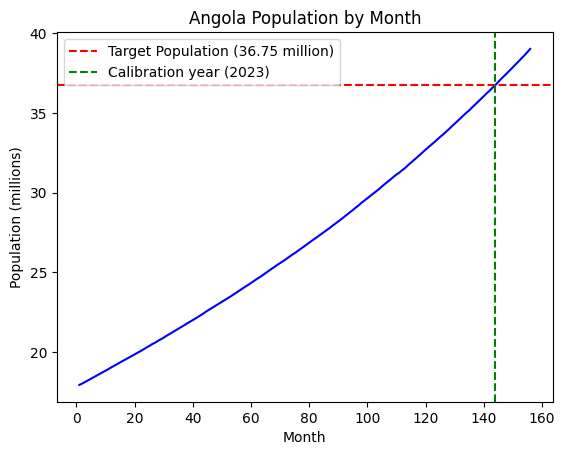

In [48]:
from matplotlib import pyplot as plt
from masim_analysis import analysis

data = analysis.get_table(f"{output_file}monthly_data_0.db", "monthly_site_data_district")
starting_pop = data[data["monthly_data_id"] == 1]["population"].sum()
last_month = data["monthly_data_id"].unique()[-13]
population_by_month = [
    data[data["monthly_data_id"] == month]["population"].sum() for month in data["monthly_data_id"].unique()
]
population_by_month = np.array(population_by_month)
ending_population = population_by_month[-13]
growth_rate = (ending_population - starting_pop) / starting_pop
projected_population = initial_population * (1 + growth_rate)
print(f"Starting population: {starting_pop}")
print(f"Ending population: {ending_population}")
print(f"Growth rate: {growth_rate}")
print(f"Projected {calibration_year} population: {projected_population}")
print(f"Percent error: {100 * (projected_population - target_population) / target_population:.4f}%")

# plots
population_scalar = population_by_month / starting_pop
plt.plot(data["monthly_data_id"].unique(), (initial_population * population_scalar) / 1_000_000, linestyle="-", color="b")
plt.axhline(y=target_population / 1_000_000, color="r", linestyle="--", label=f"Target Population ({target_population / 1_000_000:.2f} million)")
plt.axvline(x=last_month, color="g", linestyle="--", label=f"Calibration year ({calibration_year})")
plt.xlabel("Month")
plt.ylabel("Population (millions)")
plt.title(f"{long_name} Population by Month")
plt.legend()
plt.savefig(os.path.join("images", name, f"{name}_population_by_month.png"))
plt.show()

You should shoot for an absolute error of less than 2%. Finally we'll add in the target case information.

In [49]:
target_count = 9_098_006
lower_bound =  8_500_000
upper_bound =  10_500_000

With that achieved, we can now save off these initial configuration parameters.

In [50]:
import json
from masim_analysis.configure import CountryParams

country = CountryParams(
    name,
    long_name,
    age_distribution,
    birth_rate,
    calibration_year,
    death_rate,
    initial_age_structure,
    target_population,
    starting_date,
    ending_date,
    start_of_comparison_period,
    target_count,
    lower_bound,
    upper_bound,
)
with open(os.path.join("conf", name, "test", f"{name}_country_params.json"), "w") as f:
    f.write(json.dumps(country.to_dict(), indent=4))

Now you can use the below code block to load these parameters.

In [51]:
import os
from masim_analysis.configure import CountryParams

country = CountryParams.load(name="ago")

---

## Seasonality Calibration

Seasonality is a something of a manual process to fit precisely. The goal is to fit a curve that gives a scalar parameter that modifies the incidence rate for each day of the year. This is written to a `.csv` file historically called "adjustment" or "rainfall" and is a simple row-wise list of scalar values that effect the overall incidence or biting rate. This notebook choose to save this output as `seasonality.csv` in the `data/<country>/calibration` directory.

As we know from previous work, the seasonality of malaria (and most diseases) is roughly sinusoidal. The goal is to fit a sinusoidal curve to the data. With that as well the working assumption of the Boni Lab is to use the positive half of the sine curve. There is not a strong stance on this as seasonal incidence modeling is not a major research concern of the lab. Simply put, taking the positive half of the sine curve is what previous publications from the lab has done and to avoid unneccesary problems in the peer review process, we will continue to do this. This notebook will walk through the process for the full sine curve for completeness' sake.

The fitting is done using the `scipy.optimize.curve_fit` function. The function takes in a model function and the data to fit. The model function is a sinusoidal function with a phase shift, period, amplitude, and offset.

$$
s(x) = A \sin\left(\frac{2 \pi x}{P} + \phi\right) + B
$$

We are looking to fit a scalar multiplier of the base incidence data not a curve over the specific incidence. We can do this by normalizing the incidence data about the median, mean, or mode.

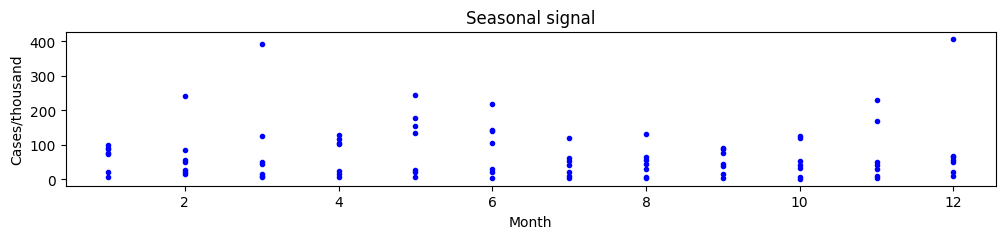

In [52]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from masim_analysis.configure import CountryParams
from pathlib import Path

country = CountryParams.load(name="ago")

data = pd.read_csv(Path("data") / country.country_code / f"{country.country_code}_incidence_data.csv")
data.dropna(inplace=True)
# data["day"] = 1
# data["date"] = pd.to_datetime(data[["day", "month", "year"]])

x = data["month"].to_numpy()
y = data["cases"].to_numpy()

fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(x, y, ".b", label="Data")
ax.set_xlabel("Month")
ax.set_ylabel("Cases/thousand")
ax.set_title("Seasonal signal")
plt.savefig(os.path.join("images", country.country_code, f"{country.country_code}_seasonal_signal.png"))
plt.show()

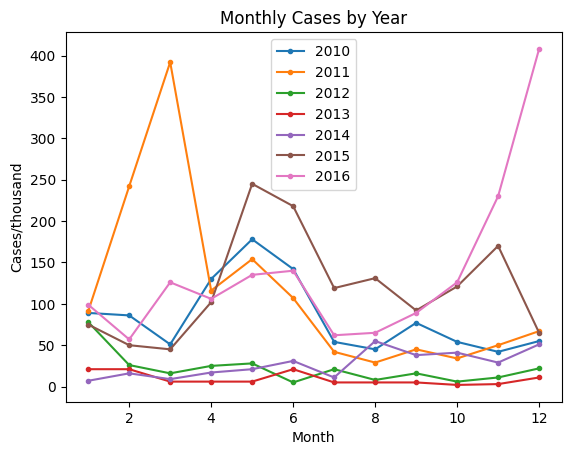

In [53]:
year_2010 = data.iloc[0:12]
year_2011 = data.iloc[12:24]
year_2012 = data.iloc[24:36]
year_2013 = data.iloc[36:48]
year_2014 = data.iloc[48:60]
year_2015 = data.iloc[60:72]
year_2016 = data.iloc[72:84]

plt.plot(year_2010["month"], year_2010["cases"], ".-", label="2010")
plt.plot(year_2011["month"], year_2011["cases"], ".-", label="2011")
plt.plot(year_2012["month"], year_2012["cases"], ".-", label="2012")
plt.plot(year_2013["month"], year_2013["cases"], ".-", label="2013")
plt.plot(year_2014["month"], year_2014["cases"], ".-", label="2014")
plt.plot(year_2015["month"], year_2015["cases"], ".-", label="2015")
plt.plot(year_2016["month"], year_2016["cases"], ".-", label="2016")
plt.legend()
plt.xlabel("Month")
plt.ylabel("Cases/thousand")
plt.title("Monthly Cases by Year")
plt.savefig(os.path.join("images", country.country_code, f"{country.country_code}_monthly_cases_by_year.png"))
plt.show()

Cleaning done for Angola.

In [54]:
data_clean = data.copy()
data_clean

,month,year,cases
0,1,2010,89
1,2,2010,86
2,3,2010,51
3,4,2010,130
4,5,2010,178
...,...,...,...
79,8,2016,65
80,9,2016,89
81,10,2016,126
82,11,2016,230


In [55]:
data_clean.drop(index=data_clean.loc[data_clean["year"] == 2012].index, inplace=True)
data_clean.drop(index=data_clean.loc[data_clean["year"] == 2013].index, inplace=True)
data_clean.drop(index=data_clean.loc[data_clean["year"] == 2014].index, inplace=True)

In [56]:
x = data_clean["month"].to_numpy()
y = data_clean["cases"].to_numpy()

End cleaning done for Angola.

In [57]:
from scipy.stats import mode as spmode
import numpy as np

median = float(np.median(y))
mean = float(np.mean(y))
mode = float(spmode(y).mode)

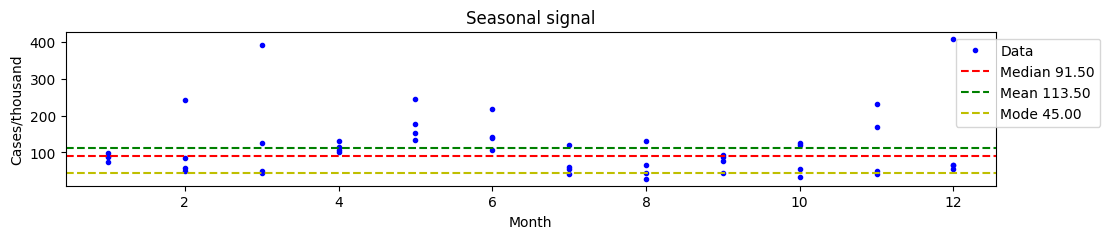

In [58]:
fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(x, y, ".b", label="Data")
ax.set_xlabel("Month")
ax.set_ylabel("Cases/thousand")
ax.set_title("Seasonal signal")
ax.axhline(median, color="r", linestyle="--", label=f"Median {median:.2f}")
ax.axhline(mean, color="g", linestyle="--", label=f"Mean {mean:.2f}")
ax.axhline(mode, color="y", linestyle="--", label=f"Mode {mode:.2f}")
ax.legend(loc="upper right", bbox_to_anchor=(1.12, 1))
plt.savefig(os.path.join("images", country.country_code, f"{country.country_code}_seasonal_signal_means.png"))
plt.show()

Normailze the data with respect to the mean value.

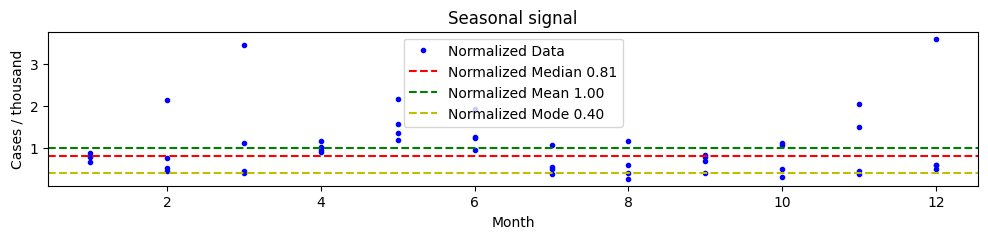

In [59]:
y_norm = y / mean

fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(x, y_norm, ".b", label="Normalized Data")
ax.set_xlabel("Month")
ax.set_ylabel("Cases / thousand")
ax.set_title("Seasonal signal")
ax.axhline(median / mean, color="r", linestyle="--", label=f"Normalized Median {median / mean:.2f}")
ax.axhline(mean / mean,   color="g", linestyle="--", label=f"Normalized Mean {mean / mean:.2f}")
ax.axhline(mode / mean,   color="y", linestyle="--", label=f"Normalized Mode {mode / mean:.2f}")
ax.legend()
plt.savefig(os.path.join("images", country.country_code, f"{country.country_code}_seasonal_signal_normalized.png"))
plt.show()

Run the curve fit function and analyze with respect to both the full sinusoid and the positive half of the sine curve. Models of these functions are found in the `calibrate` module.

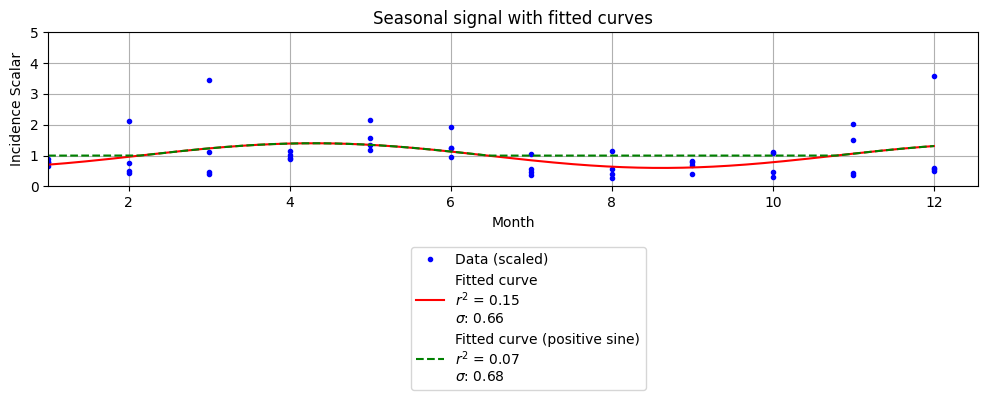

In [60]:
from scipy.optimize import curve_fit
from masim_analysis.calibrate import sinusoidal, positive_sinusoidal

x_fit = x
p0 =[1, 12, 0, 1]
fit = curve_fit(sinusoidal, x, y_norm, p0)

coefs = fit[0]

t = np.linspace(1, 12, 1000)

full_sine = sinusoidal(x_fit, *coefs)
r2 = 1 - (np.sum((y_norm - full_sine) ** 2) / np.sum((y_norm - np.mean(y_norm)) ** 2))
std_dev = np.std(y_norm - full_sine)

positive_sine = positive_sinusoidal(x_fit, *coefs)
r2_positive = 1 - (np.sum((y_norm - positive_sine) ** 2) / np.sum((y_norm - np.mean(y_norm)) ** 2))
std_dev_positive = np.std(y_norm - positive_sine)

fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(x, y_norm, ".b", label="Data (scaled)")
ax.plot(t, sinusoidal(t, *coefs), "r-", label=f"Fitted curve\n$r^2$ = {r2:0.2f}\n$\\sigma$: {std_dev:0.2f}")
ax.plot(
    t,
    positive_sinusoidal(t, *coefs),
    "g--",
    label=f"Fitted curve (positive sine)\n$r^2$ = {r2_positive:0.2f}\n$\\sigma$: {std_dev_positive:0.2f}",
)
ax.set_xlabel("Month")
ax.set_ylabel("Incidence Scalar")
ax.set_yticks([0, 1, 2, 3, 4, 5])
#ax.set_xticks(data["date"])
#ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xlim(left=1)
ax.set_ylim(bottom=0)

ax.legend(loc="upper right", bbox_to_anchor=(0.65, -0.35))
ax.grid(True)
plt.title("Seasonal signal with fitted curves")
plt.savefig(os.path.join("images", country.country_code, f"{country.country_code}_seasonal_signal_fitted.png"), bbox_inches="tight")
plt.show()

The fit is not great, but this is a relatively minor aspect of the simulation. The point is to introduce some degree of seasonal variation that is reasonable. Now let's transform the fit back to the incidence rate.

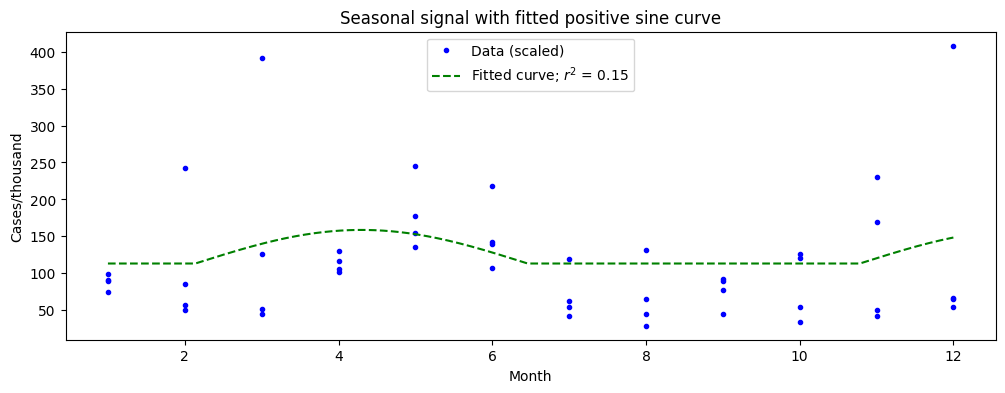

In [61]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(x_fit, y, ".b", label="Data (scaled)")
ax.plot(t, positive_sinusoidal(t, *coefs) * mean, "g--", label="Fitted curve; $r^2$ = %.2f" % r2)
ax.legend()
ax.set_xlabel("Month")
ax.set_ylabel("Cases/thousand")
ax.set_title("Seasonal signal with fitted positive sine curve")
fig.savefig(os.path.join("images", country.country_code, f"{country.country_code}_seasonal_signal_fitted_positive.png"))
plt.show()

In [62]:
# Write the fit to a file for 365 days
fit_x = np.arange(1, 366)
fit_y = positive_sinusoidal(fit_x, *fit[0])
data = pd.DataFrame({"day": fit_x, "cases/thousand": fit_y})
data = data.set_index("day")

unique_districts = list(set(districts.flatten()))
valid_districts = [int(d) for d in unique_districts if d == d]

all_district_pattern_df = pd.DataFrame()
for district in sorted(valid_districts): 
    pattern_df = data.T 
    pattern_df.columns = [f"day{i+1}" for i in range(len(pattern_df.columns))]
    pattern_df.insert(0, "admin_unit_id", district)
    all_district_pattern_df = pd.concat([all_district_pattern_df, pattern_df], ignore_index=True)
    
all_district_pattern_df.to_csv(os.path.join("data", name, f"{name}_seasonality.csv"), index=False)

# If valid districts > 1, then create a new file with the pattern format for 1 location only
if len(valid_districts) > 1:
    first_district_pattern_df = all_district_pattern_df[all_district_pattern_df['admin_unit_id'] == valid_districts[0]]
    first_district_pattern_df.to_csv(os.path.join("data", name, f"{name}_seasonality_1_location.csv"), index=False)


---

## Treatment Seeking Raster Adjustment

The treatment seeking or treatment access rate raster is a percentage. It may be given as a value between 0 and 1 or between 0 and 100. The MaSim simulation expects this raster to be in the range of 0 to 1. If the raster is in the range of 0 to 100, we need to divide the raster by 100 to get it into the correct range.

In [63]:
from pathlib import Path
from masim_analysis import utils
from masim_analysis.configure import CountryParams
import numpy as np

country = CountryParams.load("ago")

raster, meta = utils.read_raster(Path("data") / country.country_code / f"{country.country_code}_treatmentseeking.asc")
if np.nanmax(raster) > 1.0:
    print("Raster appears to be in the range 0-100. Dividing by 100 to convert to 0-1 range.")
    raster /= 100.0

print(f"Treatment seeking rates: {np.unique(raster)}")

utils.write_raster(raster, Path("data") / country.country_code / f"{country.country_code}_treatmentseeking.asc", meta["xllcorner"], meta["yllcorner"])

Treatment seeking rates: [0.366 0.416 0.446 0.46  0.465 0.468 0.48  0.494 0.502 0.533 0.54  0.569
 0.573 0.585 0.594 0.608 0.638 0.853   nan]


---

## Transfer to Nessun Dorma

At this point all the necessary configuration and data files should be in place to run the calibration batch jobs on the Nessun Dorma cluster. The next step is to transfer the necessary files to the cluster and set up the job scripts to run the calibration jobs. 

At the moment the current workflow is to check the updated data files into the git repository and then clone or pull the updates onto the Nessun Dorma cluster.

You can use the commands utility to manually setup and generate the calibration commands and jobs scripts, or alternatively you can use the below job script to automatically set up the directories, run the calibration, and validation in one go. This first requires that you set up and build the virtual environment on Nessun Dorma (use the set up script: `scripts/server_build.sh`). Once that is done you can use the below job script as a template to run the calibration and validation.

```bash
#!/bin/bash
#PBS -l walltime=240:00:00
#PBS -N <country code>
#PBS -q nd
#PBS -l select=1:ncpus=110:host=<target node>
#PBS -o ./<country name>.output
#PBS -e ./<country name>.error
#PBS -m bae
#PBS -M <your email>

cd $PBS_O_WORKDIR

source .venv/bin/activate

# Check if the calibrate command installed via the python venv is available
if ! command -v calibrate &> /dev/null
then
    echo "calibrate command could not be found. Ensure the virtual environment is set up correctly."
    exit 1
fi

commands setup <country code>

calibrate <country code> -r 20

echo "Calibration for <country name> completed."
echo "================================"
echo "Running validation now."

validate <country code> -r 50

```

Save that script as `<country code>.pbs` and submit it to the Nessun Dorma cluster using the `qsub` command:

```bash
qsub <country code>.pbs
```

When finished use `scp` to transfer the output files back to your local machine for analysis (typically in `output/<country code>/calibration`, `output/<country code>/validation`, `data/<country code>/<country code>_beta.asc`, and `images/<country code>/`).

---

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

from pandas import read_csv

from masim_analysis import analysis, calibrate, commands, configure, utils
from masim_analysis.configure import CountryParams


from ruamel.yaml import YAML


yaml = YAML()

country = CountryParams.load("ago")
country_code = 'ago'


output = Path("output") / 'ago'

In [ ]:
ave_cases = read_csv(output / 'validation' / "ave_cases.csv", index_col=0)
ave_population = read_csv(output / 'validation' / "ave_population.csv", index_col=0)
ave_prevalence_2_to_10 = read_csv(output / 'validation' / "ave_prevalence_2_to_10.csv", index_col=0)
ave_cases_2_to_10 = read_csv(output / 'validation' / "ave_cases_2_to_10.csv", index_col=0)
ave_prevalence_under_5 = read_csv(output / 'validation' / "ave_prevalence_under_5.csv", index_col=0)
ave_cases_under_5 = read_csv(output / 'validation' / "ave_cases_under_5.csv", index_col=0)

In [ ]:
mean_cases, mean_prevalence_2_to_10, mean_prevalence_under_5, mean_population = calibrate.get_last_year_statistics(
    ave_cases, ave_prevalence_2_to_10, ave_prevalence_under_5, ave_population
)

In [ ]:
country.lower_bound_case_count

In [ ]:
mean_population

In [ ]:
print(f"Mean cases: {mean_cases['mean'].sum() * 4: ,}")  # Annualize the mean cases
print(f"Observed cases lower bound: {country.lower_bound_case_count: ,}")
print(f"Observed cases upper bound: {country.upper_bound_case_count: ,}")
print(f"Observed population: {mean_population['mean'].sum() * 4: ,}")


In [ ]:
population = utils.read_raster(Path("data") / country.country_code / f"{country.country_code}_initialpopulation.asc")[0]

In [ ]:
np.nansum(population)

In [ ]:
mean_population['mean'].sum() * 4